In [66]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fftpack import fft
from scipy.signal import argrelextrema
import pandas as pd

In [105]:
def sine_fit(x, y, plot=True):
    """Estimate parameters of a noisy sine wave by FFT and non-linear fitting."""
    
    # Define the sine function
    def sine_func(x, offs, amp, f, phi):
        return offs + amp * np.sin(2 * np.pi * f * x + phi)
    
    # Estimate frequency using FFT
    N = len(y)
    f = np.linspace(0, 1, N)  # Frequency range
    yf = fft(y)
    estimate_f = f[np.argmax(np.abs(yf[1:N//2]))]  # Exclude offset
    
    # Initial guess for the parameters
    guess = [np.mean(y), np.std(y), estimate_f, 0]
    
    # Perform the fit
    popt, pcov = curve_fit(sine_func, x, y, p0=guess)
    
    # Calculate mean squared error
    mse = np.mean((y - sine_func(x, *popt)) ** 2)
    
    # Append MSE to parameters
    popt = np.append(popt, mse)
    
    # Plot if requested
    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(x, y,'o', 'b-', label='data')
        x = np.linspace(x[0], x[-1], 1000)
        plt.plot(x, sine_func(x, *popt[:-1]), 'r-', label='fit')
        plt.legend()
        plt.show()
    
    return popt

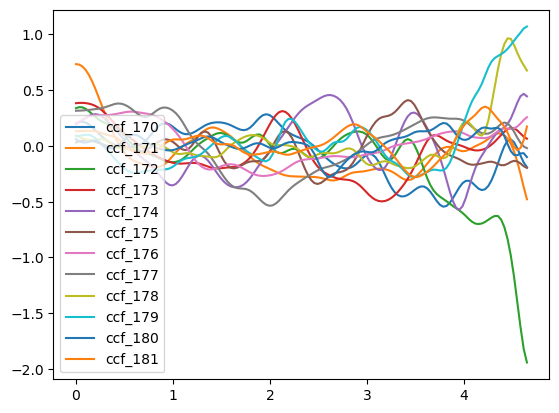

In [106]:
df = pd.read_csv('ccf_parameters.csv')
x = df['lags']
i = 0
count = 0
n = 12
idx = np.zeros(n)
fig, ax = plt.subplots()

while count < n:
    y = df[f'ccf_{i}']
    # check if y is all Nan
    if not np.isnan(y).all():
        ax.plot(x, y ,label=f'ccf_{i}')
        idx[count] = i
        count += 1
    i += 1

ax.legend()
plt.show()

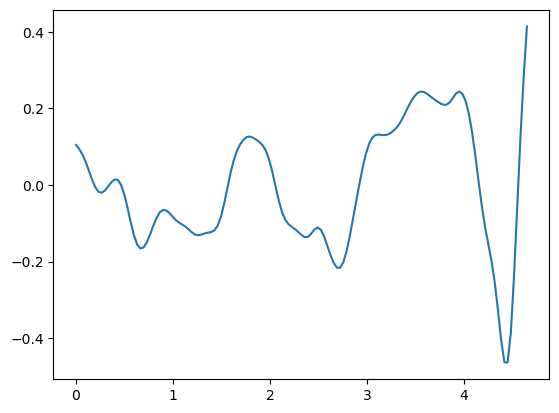

In [107]:
x = df['lags'].to_numpy()
y = df['ccf_182'].to_numpy()
plt.plot(x,y)

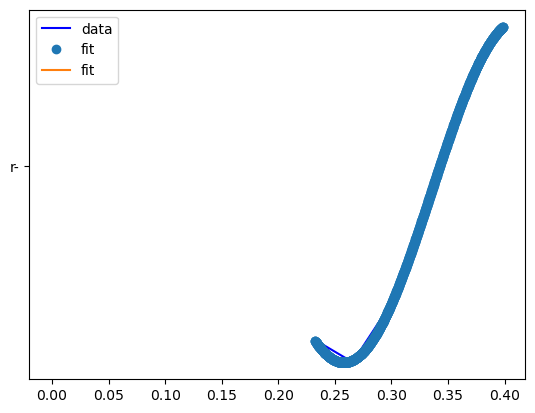

[-2.53562389e-03  1.77108226e-02  3.21546846e+00 -6.77637270e+00
  1.49926059e-08]


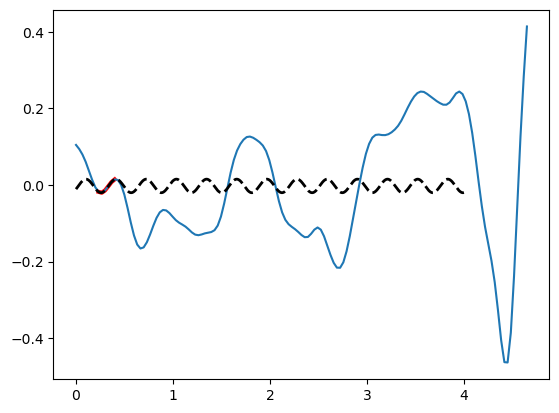

In [108]:
x = df['lags'].to_numpy()
y = df['ccf_182'].to_numpy()
sinefit = True
# find local maxima
max_idx = argrelextrema(y, np.greater)
# find local minima
min_idx = argrelextrema(y, np.less)

# find first maximum and minimum
max_1_idx = max_idx[0][0] if len(max_idx[0]) > 0 else None
min_1_idx = min_idx[0][0] if len(min_idx[0]) > 0 else None


# crop signal
if max_idx is not None and min_idx is not None:
    if max_1_idx < min_1_idx:
        start = max_1_idx
        end = min_1_idx
        
        # find second maximum
        right_extremum_idx = max_idx[0][1] if len(max_idx[0]) > 1 else None
    else:
        start = min_1_idx
        end = max_1_idx
        
        # find second minimum
        right_extremum_idx = min_idx[0][1] if len(min_idx[0]) > 1 else None
    
    diff_left = np.abs(y[0]-y[start])
    if right_extremum_idx is not None:
        diff_right = np.abs(y[right_extremum_idx]-y[end])
        diff = max(diff_left, diff_right)
        start = np.argmin(np.abs(np.abs(y[:start]) - diff / 10))
        end = end + np.argmin(np.abs(np.abs(y[end+1:right_extremum_idx+1]) - diff / 10)) + 1
    else:
        diff = diff_left
        start = np.argmin(np.abs(np.abs(y[:start]) - diff / 10))
        end = end + np.argmin(np.abs(np.abs(y[end+1:]) - diff / 10)) + 1
    
    


    y_crop = y[start:end]
    x_crop = x[start:end]
    if sinefit:
        # fit sine wave
        params = sine_fit(x_crop, y_crop)
        print(params)
    
fig, ax = plt.subplots()
ax.plot(x_crop, y_crop, 'red', lw=3)
ax.plot(x, y)
# plot sine wave
if sinefit:
    x = np.linspace(0, 4, 1000)
    ax.plot(x, params[0] + params[1] * np.sin(2 * np.pi * params[2] * x + params[3]), 'k--', lw=2)

plt.show()

In [109]:
np.abs(np.abs(y[end+1:right_extremum_idx+1])-diff_right/10)


array([0.0177811 , 0.00708877, 0.04179123, 0.07987718, 0.11389139,
       0.13766575, 0.14796417])

In [101]:
diff_right/10

0.018046403767144968

In [102]:
end

13

In [103]:
end

13